In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import astropy.constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
import fitsio
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
from Secrest_dipole import SecrestDipole
import ellisbaldwin

## Quaia

In [3]:
catname = 'quaia'
initial_catfn = 'quaia_G20.5.fits'
mag = 'G'
blim = 30
nside = 64

### $G\le 20.0$

In [4]:
# instantiate dipole object with the Quaia parameters, and make magnitude (maglim) and galactic plane (blim) cuts
maglim = 20.5
d = SecrestDipole(catname, initial_catfn, mag, maglim, blim=blim)

d.cut_mag()
d.cut_galactic_plane()

loading initial catalog, quaia_G20.5.fits
1295502 sources in initial catalog.
cut G > 20.5 -> 1295502 sources left.
cut |b| <= 30 -> 917566 sources left.


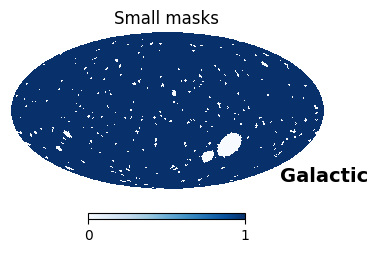

In [5]:
# load the small masks
small_masks = fitsio.read(f'/scratch/aew492/lss-dipoles_results/data/catalogs/masks/mask_master_hpx_r1.0.fits')
hp.mollview(small_masks, coord=['C','G'], title='Small masks', cmap='Blues', sub=(1,2,1))

In [6]:
# mask sources based on the small masks
masked_tab = tools.remove_masked_sources(d.table, small_masks)

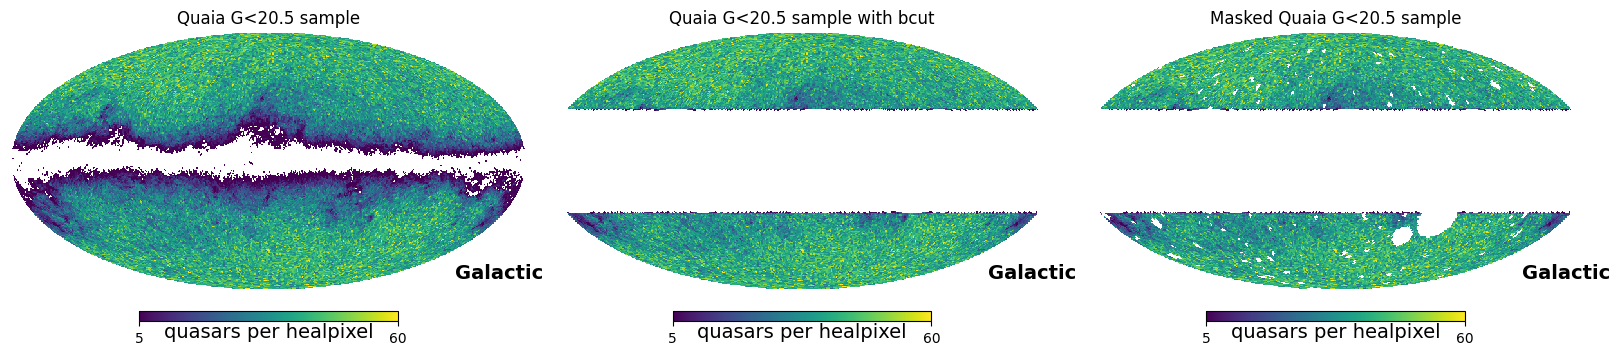

In [7]:
# check out the samples (these healpix maps are not used for any calculations here)
quaia_hpmap = tools.load_catalog_as_map(d.initial_cattab, nside=nside)
quaia_hpmap[quaia_hpmap==0.] = np.nan

quaia_hpmap_bcut = tools.load_catalog_as_map(d.table, nside=nside)
quaia_hpmap_bcut[quaia_hpmap_bcut==0.] = np.nan

masked_quaia_hpmap = tools.load_catalog_as_map(masked_tab, nside=nside)
masked_quaia_hpmap[masked_quaia_hpmap==0.] = np.nan

fig = plt.figure(figsize=(16,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig, min=5, max=60, unit='quasars per healpixel')
hp.mollview(quaia_hpmap, title='Quaia G<20.5 sample', sub=(1,3,1), **kwargs)
hp.mollview(quaia_hpmap_bcut, title='Quaia G<20.5 sample with bcut', sub=(1,3,2), **kwargs)
hp.mollview(masked_quaia_hpmap, title='Masked Quaia G<20.5 sample', sub=(1,3,3), **kwargs)

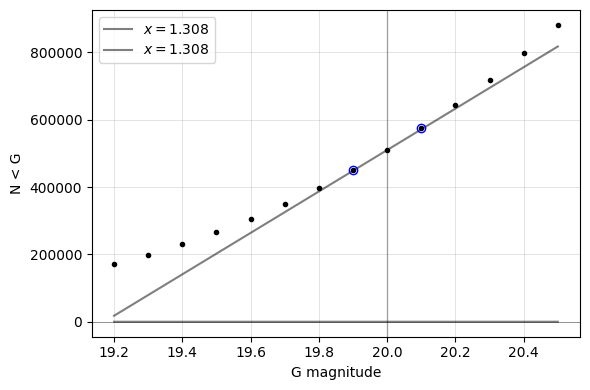

In [8]:
# NUMBER-COUNT SLOPE

# G magnitudes
g = masked_tab['phot_g_mean_mag']

# count the number of sources in bins of magnitude
width = 0.1
min_g = 19.2
max_g = 20.5
nmags = int((max_g-min_g)/width)+1
mags = np.linspace(min_g, max_g, nmags)
counts = np.array([np.sum(g<=mag) for mag in mags])

bounds = (-5,-7)
imaglim = int(np.mean(bounds))
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(mags, counts, 'k.', lw=0.5)
ax.axvline(mags[imaglim], color='k', alpha=0.3, lw=1)

ax.set_xlabel(f'{mag} magnitude')
ax.set_ylabel(f'N < {mag}')
ax.grid(lw=0.5, alpha=0.5)
ax.axhline(0., c='k', alpha=0.5, lw=0.5)

# slope of interest:
dlogN = np.log10(counts[bounds[0]])-np.log10(counts[bounds[1]])
dmags = mags[bounds[0]]-mags[bounds[1]]
x_quaia = 2.5 * (dlogN)/dmags

# "literal" slope just for plotting
m = (counts[bounds[0]] - counts[bounds[1]]) / dmags
line_quaia = m * (mags - mags[imaglim]) + counts[imaglim]
ax.plot(mags, line_quaia, c='k', alpha=0.5, label=r'$x = $'f'{x_quaia:.3f}')

curve_quaia = 10**x_quaia
ax.plot(mags, mags * curve_quaia, c='k', alpha=0.5, label=r'$x = $'f'{x_quaia:.3f}')

ax.plot(mags[bounds[0]], counts[bounds[0]], marker='o', color='None', mec='b')
ax.plot(mags[bounds[1]], counts[bounds[1]], marker='o', color='None', mec='b')

ax.legend()

mags_quaia = mags
counts_quaia = counts

cut G > 20.0 -> 530364 sources left.


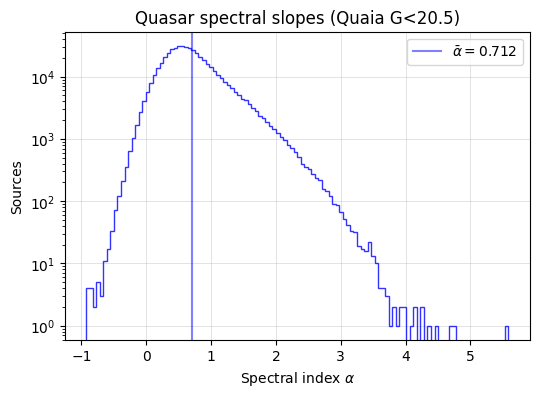

In [9]:
# ALPHAS

# make the magnitude cut to the official limit of this sample
d.maglim = 20.
d.cut_mag()
# and need to mask this table again
masked_tab = tools.remove_masked_sources(d.table, small_masks)

# magnitudes
bprp = masked_tab['phot_bp_mean_mag'] - masked_tab['phot_rp_mean_mag']

alphas_quaia = [ellisbaldwin.compute_alpha_gaia(bprp[i]) for i in range(len(masked_tab))]
alpha_quaia = np.mean(alphas_quaia)

fig, ax = plt.subplots(figsize=(6,4))
n, _, _ = ax.hist(alphas_quaia, bins=120, color='b', alpha=0.8, histtype='step')
ax.axvline(alpha_quaia, c='b', alpha=0.5, label=r'$\bar\alpha=$'f'{alpha_quaia:.3f}')
# ax.set_xlim((-1,8))
ax.set_yscale('log')
ax.set_xlabel(r'Spectral index $\alpha$')
ax.set_ylabel('Sources')
ax.set_title(f'Quasar spectral slopes (Quaia G<{maglim})')
ax.grid(alpha=0.5, lw=0.5)
ax.legend()

In [10]:
# expected dipole amplitude
ellisbaldwin.EllisBaldwin(x_quaia, alpha_quaia)

<Quantity 0.0052303>

### $G\le 20.5$

In [11]:
# instantiate dipole object with the Quaia parameters, and make magnitude (maglim) and galactic plane (blim) cuts
maglim = 20.6
initial_catfn = 'catalog_G20.6.fits'
d = SecrestDipole(catname, initial_catfn, mag, maglim, blim=blim)

d.cut_mag()
d.cut_galactic_plane()

loading initial catalog, catalog_G20.6.fits
1414385 sources in initial catalog.
cut G > 20.6 -> 1414385 sources left.
cut |b| <= 30 -> 1006085 sources left.


In [12]:
# mask sources based on the small masks
masked_tab = tools.remove_masked_sources(d.table, small_masks)

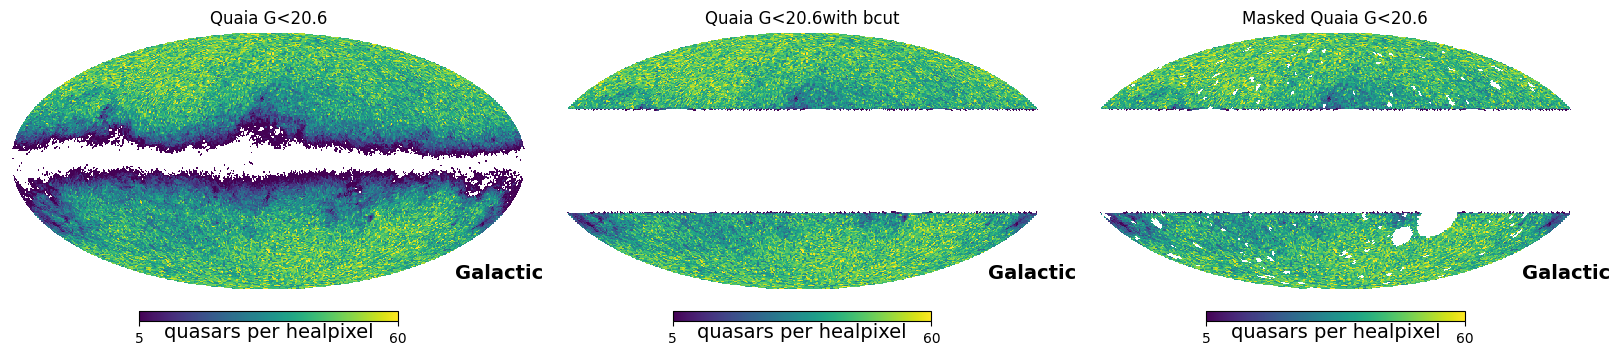

In [13]:
# check out the samples (these healpix maps are not used for any calculations here)
quaia_hpmap = tools.load_catalog_as_map(d.initial_cattab, nside=nside)
quaia_hpmap[quaia_hpmap==0.] = np.nan

quaia_hpmap_bcut = tools.load_catalog_as_map(d.table, nside=nside)
quaia_hpmap_bcut[quaia_hpmap_bcut==0.] = np.nan

masked_quaia_hpmap = tools.load_catalog_as_map(masked_tab, nside=nside)
masked_quaia_hpmap[masked_quaia_hpmap==0.] = np.nan

fig = plt.figure(figsize=(16,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig, min=5, max=60, unit='quasars per healpixel')
hp.mollview(quaia_hpmap, title=f'Quaia G<{maglim}', sub=(1,3,1), **kwargs)
hp.mollview(quaia_hpmap_bcut, title=f'Quaia G<{maglim}with bcut', sub=(1,3,2), **kwargs)
hp.mollview(masked_quaia_hpmap, title=f'Masked Quaia G<{maglim}', sub=(1,3,3), **kwargs)

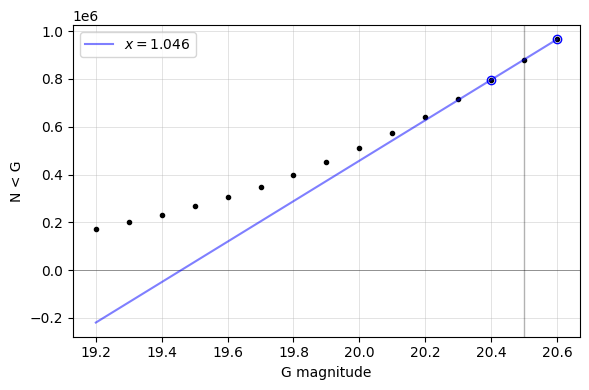

In [14]:
# NUMBER-COUNT SLOPE

# G magnitudes
g = masked_tab['phot_g_mean_mag']

# count the number of sources in bins of magnitude
width = 0.1
min_g = 19.2
max_g = 20.6
nmags = int((max_g-min_g)/width)+1
mags = np.linspace(min_g, max_g, nmags)
counts = np.array([np.sum(g<=mag) for mag in mags])

bounds = (-1,-3)
imaglim = int(np.mean(bounds))
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(mags, counts, 'k.', lw=0.5)
ax.axvline(mags[imaglim], color='k', alpha=0.3, lw=1)

ax.set_xlabel(f'{mag} magnitude')
ax.set_ylabel(f'N < {mag}')
ax.grid(lw=0.5, alpha=0.5)
ax.axhline(0., c='k', alpha=0.5, lw=0.5)

# slope of interest:
dlogN = np.log10(counts[bounds[0]])-np.log10(counts[bounds[1]])
dmags = mags[bounds[0]]-mags[bounds[1]]
x = 2.5 * (dlogN)/dmags

# "literal" slope just for plotting
m = (counts[bounds[0]] - counts[bounds[1]]) / dmags
ax.plot(mags, m * (mags - mags[imaglim]) + counts[imaglim], c='b', alpha=0.5, label=r'$x = $'f'{x:.3f}')

ax.plot(mags[bounds[0]], counts[bounds[0]], marker='o', color='None', mec='b')
ax.plot(mags[bounds[1]], counts[bounds[1]], marker='o', color='None', mec='b')

ax.legend()

cut G > 20.5 -> 917569 sources left.


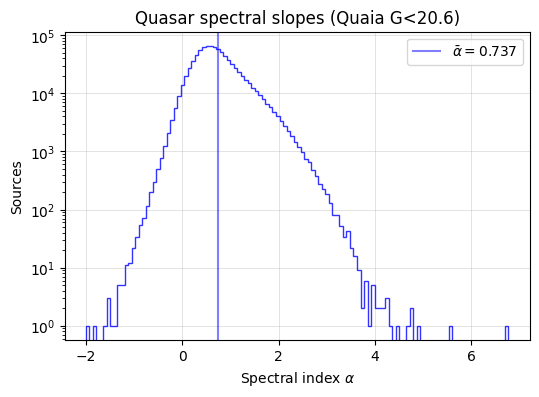

In [15]:
# ALPHAS

# make the magnitude cut to the official limit of this sample
d.maglim = 20.5
d.cut_mag()
# and need to mask this table again
masked_tab = tools.remove_masked_sources(d.table, small_masks)

# magnitudes
bprp = masked_tab['phot_bp_mean_mag'] - masked_tab['phot_rp_mean_mag']

alphas = [ellisbaldwin.compute_alpha_gaia(bprp[i]) for i in range(len(masked_tab))]
alpha = np.mean(alphas)

fig, ax = plt.subplots(figsize=(6,4))
n, _, _ = ax.hist(alphas, bins=120, color='b', alpha=0.8, histtype='step')
ax.axvline(alpha, c='b', alpha=0.5, label=r'$\bar\alpha=$'f'{alpha:.3f}')
# ax.set_xlim((-1,8))
ax.set_yscale('log')
ax.set_xlabel(r'Spectral index $\alpha$')
ax.set_ylabel('Sources')
ax.set_title(f'Quasar spectral slopes (Quaia G<{maglim})')
ax.grid(alpha=0.5, lw=0.5)
ax.legend()

In [16]:
ellisbaldwin.EllisBaldwin(x, alpha)

<Quantity 0.00470832>

### `zsplit2`

In [30]:
# get the median redshift in the G<20.0 CATALOG
d = SecrestDipole(catname, 'quaia_G20.0.fits', mag, 20., blim=blim)
d.cut_mag()
# d.cut_galactic_plane()
zmedian = np.median(d.table['redshift_quaia'])
print(f"median redshift is {zmedian:.3f}")

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.
cut G > 20.0 -> 755850 sources left.
median redshift is 1.451


In [31]:
# instantiate the full G20.5 catalog object
maglim = 20.5
initial_catfn = 'quaia_G20.5.fits'
d = SecrestDipole(catname, initial_catfn, mag, maglim, blim=blim)

d.cut_mag()
d.cut_galactic_plane()

loading initial catalog, quaia_G20.5.fits
1295502 sources in initial catalog.
cut G > 20.5 -> 1295502 sources left.
cut |b| <= 30 -> 917566 sources left.


In [32]:
# split the G20.5 catalog at the median redshift:
tab_zsplit2bin0 = d.table[d.table['redshift_quaia'] <= zmedian]
tab_zsplit2bin1 = d.table[d.table['redshift_quaia'] > zmedian]

In [33]:
# mask sources based on the small masks
masked_tab_bin0 = tools.remove_masked_sources(tab_zsplit2bin0, small_masks)
masked_tab_bin1 = tools.remove_masked_sources(tab_zsplit2bin1, small_masks)

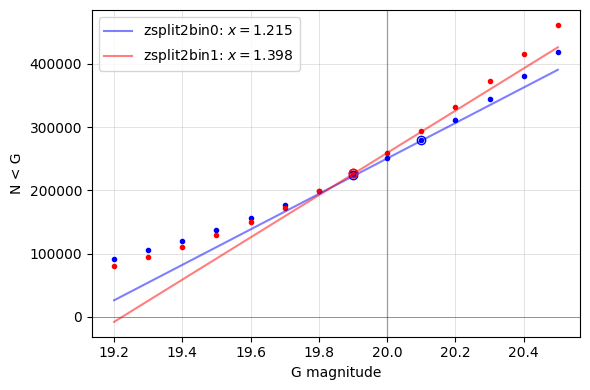

In [34]:
# NUMBER-COUNT SLOPE

# G magnitudes
g_bin0 = masked_tab_bin0['phot_g_mean_mag']
g_bin1 = masked_tab_bin1['phot_g_mean_mag']

# count the number of sources in bins of magnitude
width = 0.1
min_g = 19.2
max_g = 20.5
nmags = int((max_g-min_g)/width)+1
mags = np.linspace(min_g, max_g, nmags)
counts_bin0 = np.array([np.sum(g_bin0<=mag) for mag in mags])
counts_bin1 = np.array([np.sum(g_bin1<=mag) for mag in mags])

bounds = (-5,-7)
imaglim = int(np.mean(bounds))
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(mags, counts_bin0, 'b.', lw=0.5)
ax.plot(mags, counts_bin1, 'r.', lw=0.5)
ax.axvline(mags[imaglim], color='k', alpha=0.3, lw=1)

ax.set_xlabel(f'{mag} magnitude')
ax.set_ylabel(f'N < {mag}')
ax.grid(lw=0.5, alpha=0.5)
ax.axhline(0., c='k', alpha=0.5, lw=0.5)

# slope of interest:
dmags = mags[bounds[0]]-mags[bounds[1]]
dlogN_bin0 = np.log10(counts_bin0[bounds[0]])-np.log10(counts_bin0[bounds[1]])
dlogN_bin1 = np.log10(counts_bin1[bounds[0]])-np.log10(counts_bin1[bounds[1]])
x_bin0 = 2.5 * (dlogN_bin0)/dmags
x_bin1 = 2.5 * (dlogN_bin1)/dmags

# "literal" slope just for plotting
m_bin0 = (counts_bin0[bounds[0]] - counts_bin0[bounds[1]]) / dmags
m_bin1 = (counts_bin1[bounds[0]] - counts_bin1[bounds[1]]) / dmags
ax.plot(mags, m_bin0 * (mags - mags[imaglim]) + counts_bin0[imaglim], c='b', alpha=0.5, label=r'zsplit2bin0: $x = $'f'{x_bin0:.3f}')
ax.plot(mags, m_bin1 * (mags - mags[imaglim]) + counts_bin1[imaglim], c='r', alpha=0.5, label=r'zsplit2bin1: $x = $'f'{x_bin1:.3f}')

ax.plot(mags[bounds[0]], counts_bin0[bounds[0]], marker='o', color='None', mec='b')
ax.plot(mags[bounds[1]], counts_bin0[bounds[1]], marker='o', color='None', mec='b')
ax.plot(mags[bounds[1]], counts_bin1[bounds[1]], marker='o', color='None', mec='r')
ax.plot(mags[bounds[1]], counts_bin1[bounds[1]], marker='o', color='None', mec='r')

ax.legend()

cut G > 20.0 -> 530364 sources left.


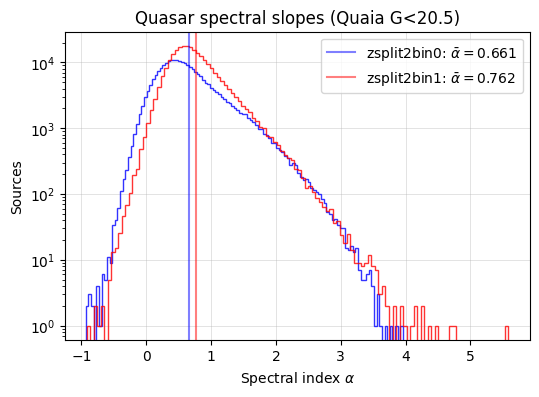

In [35]:
# ALPHAS

# make the magnitude cut to the official limit of this sample
d.maglim = 20.
d.cut_mag()
# and need to split and (smaller) mask this table again
tab_zsplit2bin0 = d.table[d.table['redshift_quaia'] <= zmedian]
tab_zsplit2bin1 = d.table[d.table['redshift_quaia'] > zmedian]
masked_tab_bin0 = tools.remove_masked_sources(tab_zsplit2bin0, small_masks)
masked_tab_bin1 = tools.remove_masked_sources(tab_zsplit2bin1, small_masks)

# magnitudes
bprp_bin0 = masked_tab_bin0['phot_bp_mean_mag'] - masked_tab_bin0['phot_rp_mean_mag']
bprp_bin1 = masked_tab_bin1['phot_bp_mean_mag'] - masked_tab_bin1['phot_rp_mean_mag']

alphas_quaia_bin0 = [ellisbaldwin.compute_alpha_gaia(bprp_bin0[i]) for i in range(len(masked_tab_bin0))]
alphas_quaia_bin1 = [ellisbaldwin.compute_alpha_gaia(bprp_bin1[i]) for i in range(len(masked_tab_bin1))]
alpha_quaia_bin0 = np.mean(alphas_quaia_bin0)
alpha_quaia_bin1 = np.mean(alphas_quaia_bin1)

fig, ax = plt.subplots(figsize=(6,4))
n, _, _ = ax.hist(alphas_quaia_bin0, bins=120, color='b', alpha=0.8, histtype='step')
n, _, _ = ax.hist(alphas_quaia_bin1, bins=120, color='r', alpha=0.8, histtype='step')
ax.axvline(alpha_quaia_bin0, c='b', alpha=0.5, label=r'zsplit2bin0: $\bar\alpha=$'f'{alpha_quaia_bin0:.3f}')
ax.axvline(alpha_quaia_bin1, c='r', alpha=0.5, label=r'zsplit2bin1: $\bar\alpha=$'f'{alpha_quaia_bin1:.3f}')
# ax.set_xlim((-1,8))
ax.set_yscale('log')
ax.set_xlabel(r'Spectral index $\alpha$')
ax.set_ylabel('Sources')
ax.set_title(f'Quasar spectral slopes (Quaia G<{maglim})')
ax.grid(alpha=0.5, lw=0.5)
ax.legend()

In [36]:
print("bin 0:")
ellisbaldwin.EllisBaldwin(x_bin0, alpha_quaia_bin0)

bin 0:


<Quantity 0.00495691>

In [37]:
print("bin 1:")
ellisbaldwin.EllisBaldwin(x_bin1, alpha_quaia_bin1)

bin 1:


<Quantity 0.00550574>

## CatWISE

In [24]:
# load catalog
catname = 'catwise_agns'
initial_catfn = 'catwise_agns_masked_bcut25.fits'
mag = 'w1'
maglim = 16.5
blim = 30
d = SecrestDipole(catname, initial_catfn, mag, maglim, blim=blim)
d.cut_mag()
d.cut_galactic_plane()

loading initial catalog, catwise_agns_masked_bcut25.fits
1824826 sources in initial catalog.
cut w1 > 16.5 -> 1824826 sources left.
cut |b| <= 30 -> 1601753 sources left.


In [25]:
# mask sources based on the small masks
masked_tab = tools.remove_masked_sources(d.table, small_masks)

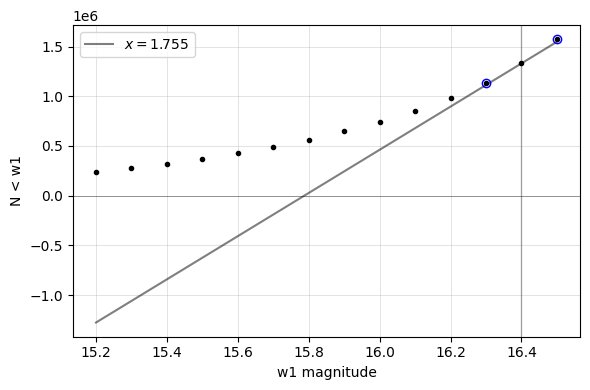

In [26]:
# NUMBER-COUNT SLOPE

w1 = masked_tab['w1']

# count the number of sources in bins of magnitude
width = 0.1
min_w1 = 15.2
max_w1 = 16.5
nmags = int((max_w1-min_w1)/width)+1
mags = np.linspace(min_w1, max_w1, nmags)
counts = np.array([np.sum(w1<=mag) for mag in mags])

bounds = (-1,-3)
imaglim = int(np.mean(bounds))
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(mags, counts, 'k.', lw=0.5)
ax.axvline(mags[imaglim], color='k', alpha=0.3, lw=1)

ax.set_xlabel(f'{mag} magnitude')
ax.set_ylabel(f'N < {mag}')
ax.grid(lw=0.5, alpha=0.5)
ax.axhline(0., c='k', alpha=0.5, lw=0.5)

# slope of interest:
dlogN = np.log10(counts[bounds[0]])-np.log10(counts[bounds[1]])
dmags = mags[bounds[0]]-mags[bounds[1]]
x_quaia = 2.5 * (dlogN)/dmags

# "literal" slope just for plotting
m = (counts[bounds[0]] - counts[bounds[1]]) / dmags
line_catwise = m * (mags - mags[imaglim]) + counts[imaglim]
ax.plot(mags, line_catwise, c='k', alpha=0.5, label=r'$x = $'f'{x_quaia:.3f}')

ax.plot(mags[bounds[0]], counts[bounds[0]], marker='o', color='None', mec='b')
ax.plot(mags[bounds[1]], counts[bounds[1]], marker='o', color='None', mec='b')

ax.legend()

mags_catwise = mags
counts_catwise = counts

cut w1 > 16.4 -> 1355409 sources left.


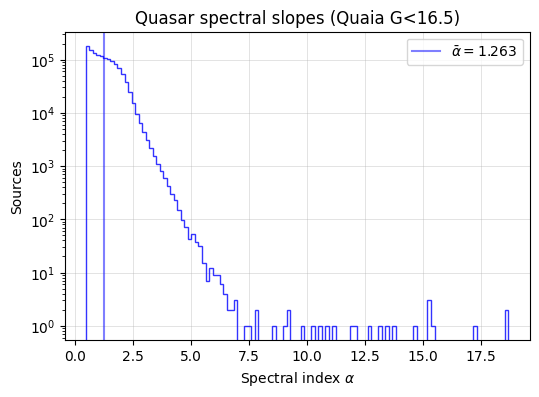

In [27]:
# ALPHAS

# make the magnitude cut to the official limit of this sample
d.maglim = 16.4
d.cut_mag()
# and need to mask this table again
masked_tab = tools.remove_masked_sources(d.table, small_masks)

# magnitudes
w12 = masked_tab['w12']

alphas_catwise = [ellisbaldwin.compute_alpha_wise(w12[i]) for i in range(len(masked_tab))]
alpha_catwise = np.mean(alphas_catwise)

fig, ax = plt.subplots(figsize=(6,4))
n, _, _ = ax.hist(alphas_catwise, bins=120, color='b', alpha=0.8, histtype='step')
ax.axvline(alpha_catwise, c='b', alpha=0.5, label=r'$\bar\alpha=$'f'{alpha_catwise:.3f}')
# ax.set_xlim((-1,8))
ax.set_yscale('log')
ax.set_xlabel(r'Spectral index $\alpha$')
ax.set_ylabel('Sources')
ax.set_title(f'Quasar spectral slopes (Quaia G<{maglim})')
ax.grid(alpha=0.5, lw=0.5)
ax.legend()

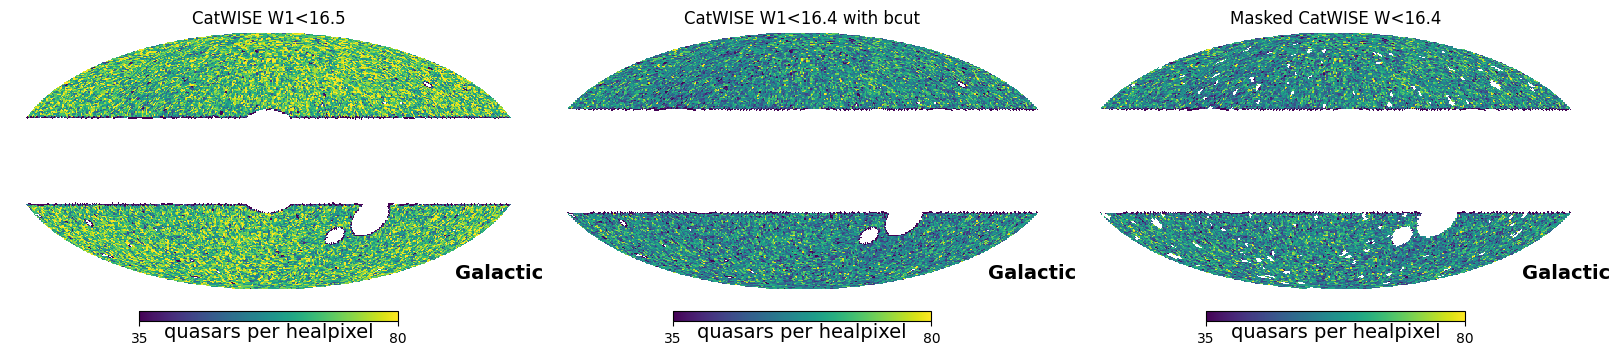

In [28]:
# check out the samples (these healpix maps are not used for any calculations here)
catwise_hpmap = tools.load_catalog_as_map(d.initial_cattab, nside=nside)
catwise_hpmap[catwise_hpmap==0.] = np.nan

catwise_hpmap_bcut = tools.load_catalog_as_map(d.table, nside=nside)
catwise_hpmap_bcut[catwise_hpmap_bcut==0.] = np.nan

masked_catwise_hpmap = tools.load_catalog_as_map(masked_tab, nside=nside)
masked_catwise_hpmap[masked_catwise_hpmap==0.] = np.nan

fig = plt.figure(figsize=(16,4))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig, min=35, max=80, unit='quasars per healpixel')
hp.mollview(catwise_hpmap, title='CatWISE W1<16.5', sub=(1,3,1), **kwargs)
hp.mollview(catwise_hpmap_bcut, title='CatWISE W1<16.4 with bcut', sub=(1,3,2), **kwargs)
hp.mollview(masked_catwise_hpmap, title='Masked CatWISE W<16.4', sub=(1,3,3), **kwargs)

### plot

In [29]:
plt.rcParams["font.family"] = "serif"

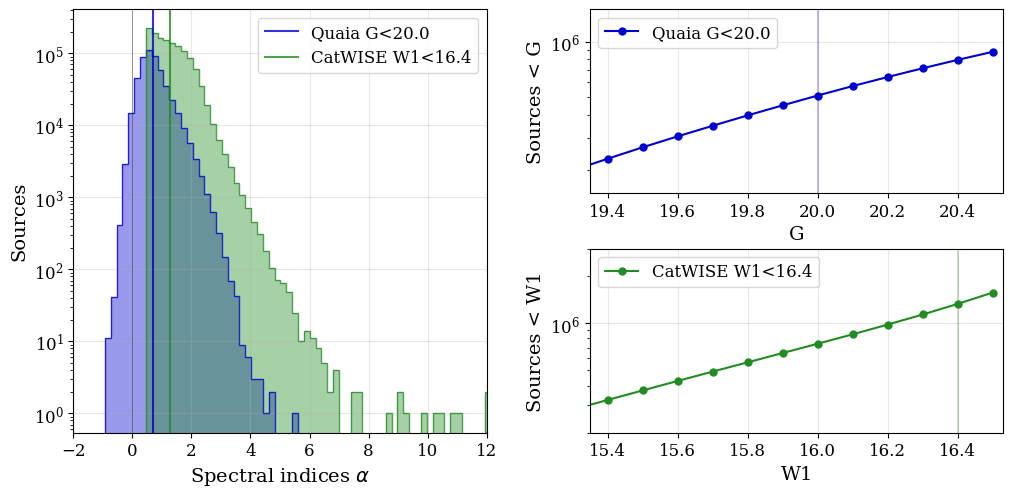

In [35]:
fig = plt.figure(figsize=(12,5.5))

mpl.rcParams.update({'font.size': 12})

labelsize = 14
c_quaia = 'mediumblue'
c_catwise = 'forestgreen'

gs = mpl.gridspec.GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.3)

ax0 = fig.add_subplot(gs[:,0])
bins = np.linspace(np.amin(np.append(alphas_quaia, alphas_catwise)), np.amax(np.append(alphas_quaia, alphas_catwise)),100)
kwargs = dict(bins=bins, alpha=0.4)
_, _, _ = ax0.hist(alphas_quaia, color=c_quaia, **kwargs)
_, _, _ = ax0.hist(alphas_catwise, color=c_catwise, **kwargs)
_, _, _ = ax0.hist(alphas_quaia, color=c_quaia, bins=bins, histtype='step', alpha=0.8)
_, _, _ = ax0.hist(alphas_catwise, color=c_catwise, bins=bins, histtype='step', alpha=0.8)
ax0.axvline(0., c='k', alpha=0.5, lw=0.5)
ax0.axvline(np.mean(alphas_quaia), c=c_quaia, alpha=0.8, label='Quaia G<20.0')
ax0.axvline(np.mean(alphas_catwise), c=c_catwise, alpha=0.8, label='CatWISE W1<16.4')
ax0.set_xlim(-2,12)
ax0.set_xlabel(r'Spectral indices $\alpha$', fontsize=labelsize)
ax0.set_ylabel('Sources', fontsize=labelsize)

ax1 = fig.add_subplot(gs[0,1])
ax1.plot(mags_quaia, counts_quaia, c=c_quaia, marker='.', ms=10, label='Quaia G<20.0')
# ax1.plot(mags_quaia, line_quaia, 'b-', lw=0.5, alpha=0.6)
ax1.axvline(20., color=c_quaia, alpha=0.3, lw=1.2)
# ax1.plot(mags_quaia[-5], counts_quaia[-5], marker='x', color='r')
# ax1.plot(mags_quaia[-7], counts_quaia[-7], marker='x', color='r')
ax1.set_xlim(19.35,20.53)
ax1.set_ylim(1.5e5,1.5e6)
ax1.set_xlabel('G', fontsize=labelsize)
ax1.set_ylabel('Sources < G', fontsize=labelsize)

ax2 = fig.add_subplot(gs[1,1])
ax2.plot(mags_catwise, counts_catwise, c=c_catwise, marker='.', ms=10, label='CatWISE W1<16.4')
# ax2.plot(mags_catwise, line_catwise, 'r-', lw=0.5, alpha=0.6)
ax2.axvline(16.4, color=c_catwise, alpha=0.3, lw=1.2)
# ax2.plot(mags[-1], counts[-1], marker='x', color='r')
# ax2.plot(mags[-3], counts[-3], marker='x', color='r')
ax2.set_xlim(15.35,16.53)
ax2.set_ylim(2e5,3e6)
ax2.set_xlabel('W1', fontsize=labelsize)
ax2.set_ylabel('Sources < W1', fontsize=labelsize)

for ax in [ax0,ax1,ax2]:
    ax.set_yscale('log')
    ax.grid(alpha=0.3)
    ax.legend()
ax1.legend(loc=2)